Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn.metrics import mean_squared_error


Preparing Data

In [2]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

# Select stocks to use; exclude the first column (date)
all_stocks = prices_df.columns[1:]
training_stocks = all_stocks[:200]
other_stocks = all_stocks[250:]

# Calculate returns
returns_df = prices_df[all_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for easier calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()


Defining Parameters

-objasnjenje- train je do starta, test od starta do enda
(godina-mjesec-dan)
min datum je 2000-01-04
max datum je 2021-07-16

In [3]:
global windows, foreacast_horizon, test_start, test_end

windows = [21, 63, 126, 252] # month, quarter, half-year, year
forecast_horizon = 21 # trading days
test_start_date = pd.to_datetime('2015-01-01')
test_end_date = pd.to_datetime('2021-07-15')

messages = {"test_start": [], "test_end": []}

# Check if test_start_date exists in the DataFrame, if not, take the next date that exists
if test_start_date not in returns_df['Date'].values:
    test_start_date = returns_df['Date'][returns_df['Date'] > test_start_date].bfill().iloc[0]
    messages["test_start"] = messages["test_start"] or ['Start date not found, using closest next date instead.']

# Check if test_end_date exists in the DataFrame, if not, take the previous date that exists
if test_end_date not in returns_df['Date'].values:
    test_end_date = returns_df['Date'][returns_df['Date'] < test_end_date].ffill().iloc[-1]
    messages["test_end"] = messages["test_end"] or ['End date not found, using closest date instead.']

test_start = returns_df.loc[returns_df['Date'] == test_start_date].index[0]
test_end = returns_df.loc[returns_df['Date'] == test_end_date].index[0]

if test_start < max(windows):
    test_start = max(windows)
    messages["test_start"] = messages["test_start"] or ['Start date too early, not enough data for training.']

if test_end > len(returns_df):
    test_end = len(returns_df)
    messages["test_end"] = messages["test_end"] or ['End date too late, not enough data for testing.']
    
if (test_end - test_start) % forecast_horizon != 0:
    test_end = test_end - (test_end - test_start) % forecast_horizon
    messages["test_end"] = messages["test_end"] or ['End date not a multiple of forecast horizon.']

if messages["test_start"]:
    print('Adjusted tart date: {}. Reason: {}'.format(returns_df['Date'][test_start], ' '.join(messages["test_start"])))
if messages["test_end"]:
    print('Adjusted end date: {}. Reason: {}'.format(returns_df['Date'][test_end], ' '.join(messages["test_end"])))

del test_start_date, test_end_date, messages

Adjusted tart date: 2015-01-02 00:00:00. Reason: Start date not found, using closest next date instead.
Adjusted end date: 2021-06-29 00:00:00. Reason: End date not a multiple of forecast horizon.


Naive Risk Parity

-objasnjenje- (inv_volatilities = inverse volatilnosti)

In [4]:
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] if volatility[stock] > 0 else 0 for stock in all_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(all_stocks))

In [5]:
methods = defaultdict(lambda: defaultdict(list))

def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"].extend([volatility[stock]])
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)


In [6]:
def reset_portfolio_metrics(method):
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"] = []
    methods[method]["returns"] = []

Perfect Prediction Method

In [7]:
method = "PerfectPrediction" + "+" + str(forecast_horizon)
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Sample Method

In [8]:
for window in windows:
    method = "Sample" + "-" + str(window)
    reset_portfolio_metrics(method)
    for i in range(test_start, test_end, forecast_horizon):
        # 
        volatility = {stock: returns_df[stock][i - window: i].std() for stock in all_stocks}

        gather_portfolio_metrics(method, i, volatility)

Equal Weight Method

In this approach, we are assuming that all stocks have the same volatility. This assumption simplifies our model by allowing us to assign equal weights to all stocks in the portfolio. However, it's important to note that this is a simplification. In reality, different stocks may have different volatilities, which could impact the optimal portfolio allocation.

In [9]:
method = "EqualWeight"
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Exponential Weight Method

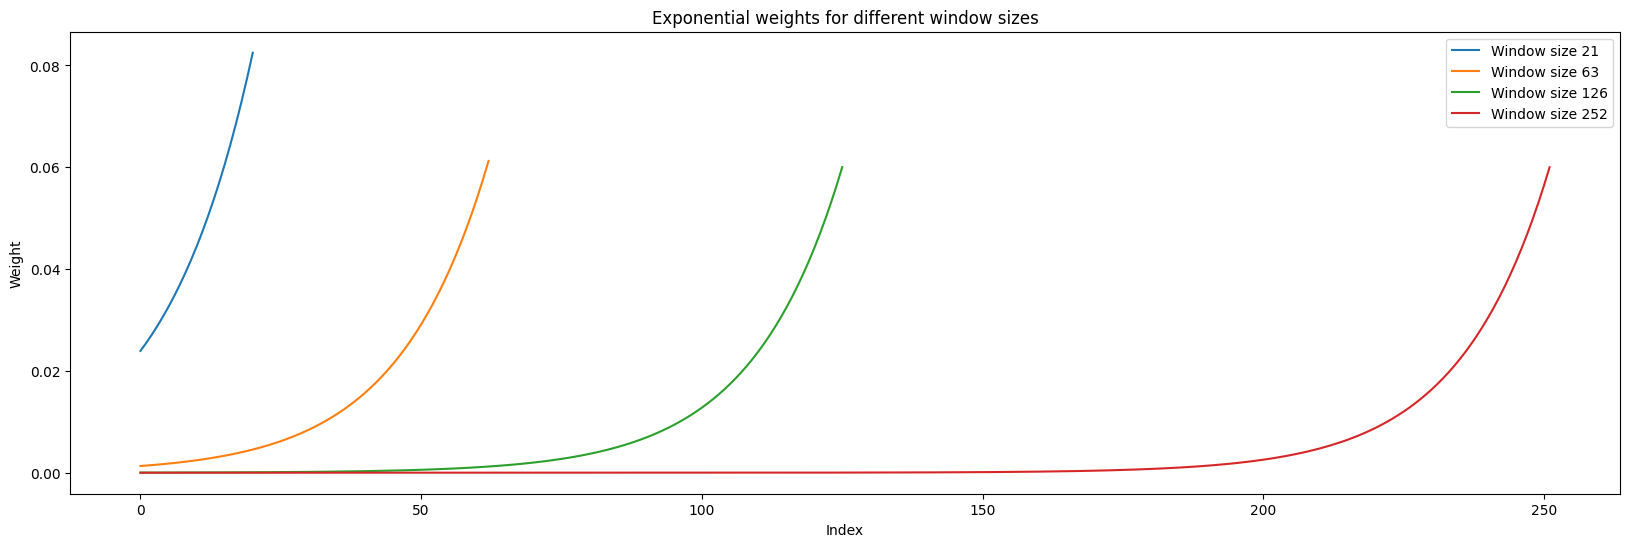

In [10]:
def get_exponential_weights(size, const=0.94):
    weights = [const**i for i in range(size, 0, -1)]
    total = sum(weights)
    return [weight / total for weight in weights]
    
plt.figure(figsize=(20, 6))
for window in windows:
    weights = get_exponential_weights(window)
    plt.plot(weights, label=f'Window size {window}')
plt.title('Exponential weights for different window sizes')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [11]:
def get_weighted_volatility(weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

for window in windows:
    method = "ExponentialWeight" + "-" + str(window)
    reset_portfolio_metrics(method)

    weights = get_exponential_weights(window)
    for i in range(test_start, test_end, forecast_horizon):
        # 
        volatility = {stock: get_weighted_volatility(weights, returns_df[stock][i - window: i]) for stock in all_stocks}

        gather_portfolio_metrics(method, i, volatility)

Least Squares Linear Regression Method

In [12]:
global window, train_start, train_end
window = 21 # Set window to 21 days from now on for computational efficiency
train_start = (test_start - window) % forecast_horizon + window # 
train_end = test_start # Training end is the start of the test period

A, B = [], []
def get_linear_regression_model(A, B, fit_intercept=True):
    # Fit a linear regression model with non-negative coefficients and no intercept
    model = LinearRegression(positive=True, fit_intercept=fit_intercept)
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

Linear Regression (return^2, variance)

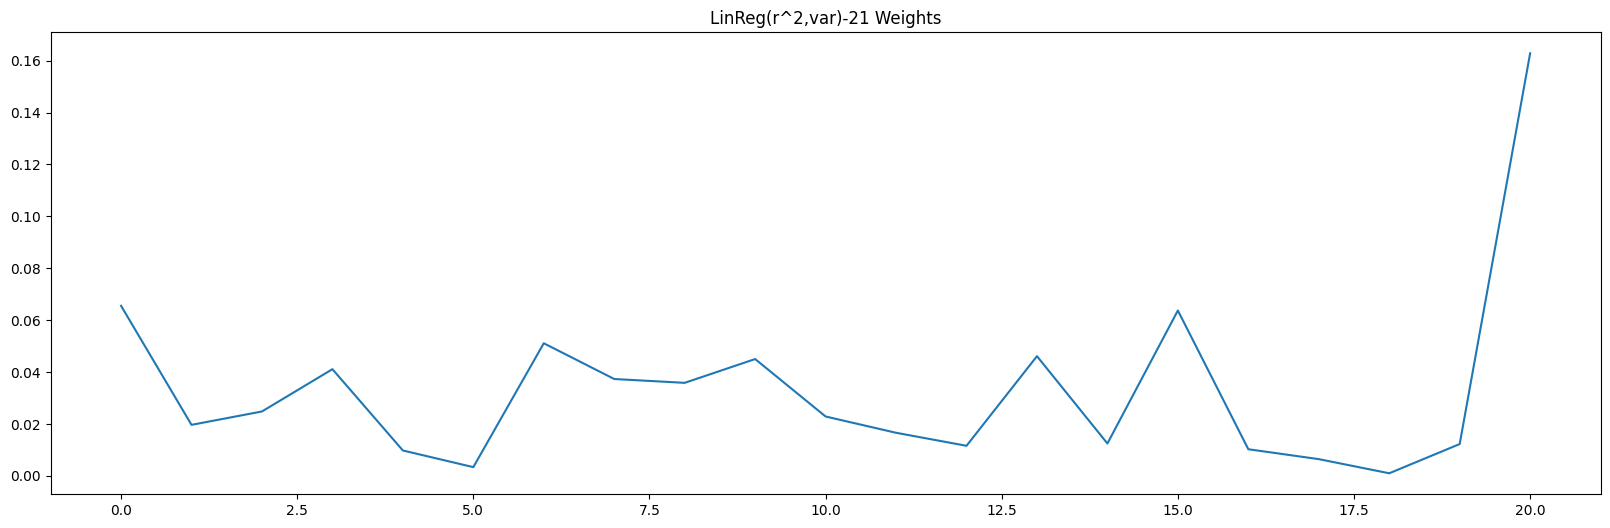

In [13]:
method = "LinReg(r^2,var)" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

methods[method]["model"] = get_linear_regression_model(A, B, False) # Intercept might make variance negative

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [14]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: methods[method]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}
    
    gather_portfolio_metrics(method, i, volatility)

Individual Linear Regression (return^2, variance)

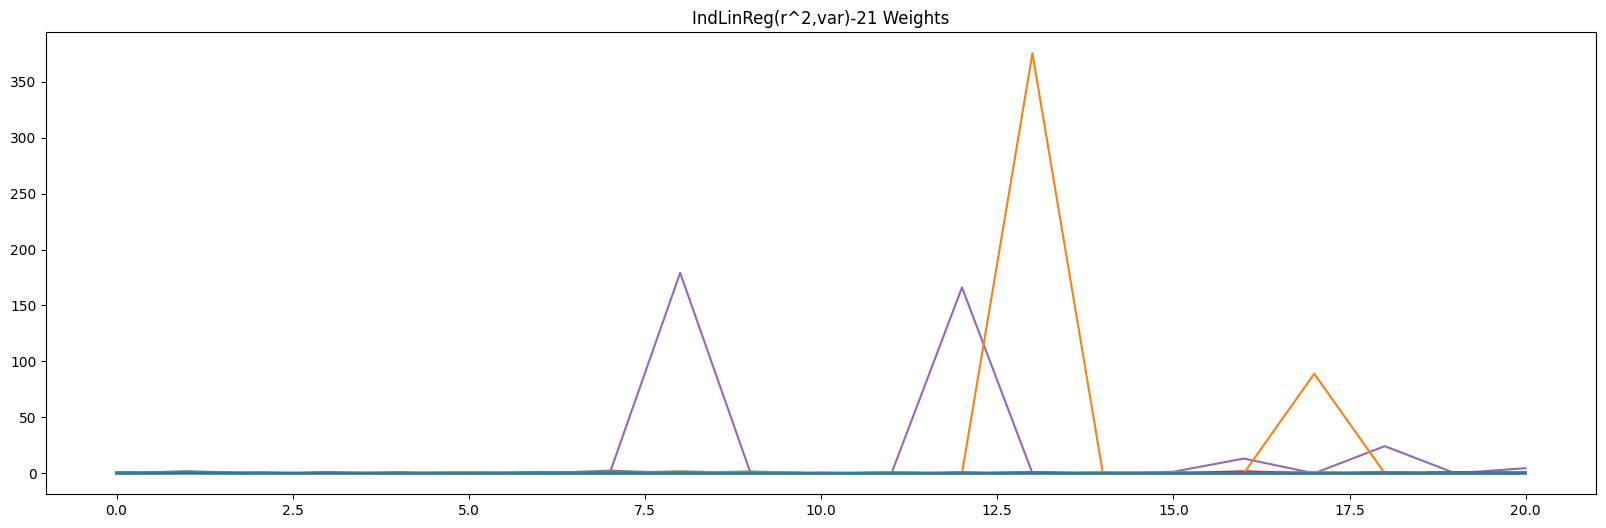

In [15]:
method = "IndLinReg(r^2,var)" + "-" + str(window)
reset_portfolio_metrics(method)

# Store individual models for each stock
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i] ** 2)
        B.append(returns_df[stock][i:i + forecast_horizon].var())

    methods[method][stock + "model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    plt.plot(methods[method][stock + "model"].coef_)
plt.title(method + " Weights")
plt.show()

In [16]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: methods[method][stock + "model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

C:\Users\MATE\AppData\Local\Temp\ipykernel_27528\619786472.py:3: RuntimeWarning: invalid value encountered in scalar power
  volatility = {stock: methods[method][stock + "model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}
C:\Users\MATE\AppData\Local\Temp\ipykernel_27528\619786472.py:3: RuntimeWarning: invalid value encountered in scalar power
  volatility = {stock: methods[method][stock + "model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}
C:\Users\MATE\AppData\Local\Temp\ipykernel_27528\619786472.py:3: RuntimeWarning: invalid value encountered in scalar power
  volatility = {stock: methods[method][stock + "model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2)[0]**0.5 for stock in all_stocks}
C:\Users\MATE\AppData\Local\Temp\ipykernel_27528\619786472.py:3: RuntimeWarning: invalid value encountered in scalar power
  volatility = {stock: methods[method][s

Linear Regression (log(1+return), log(variance))

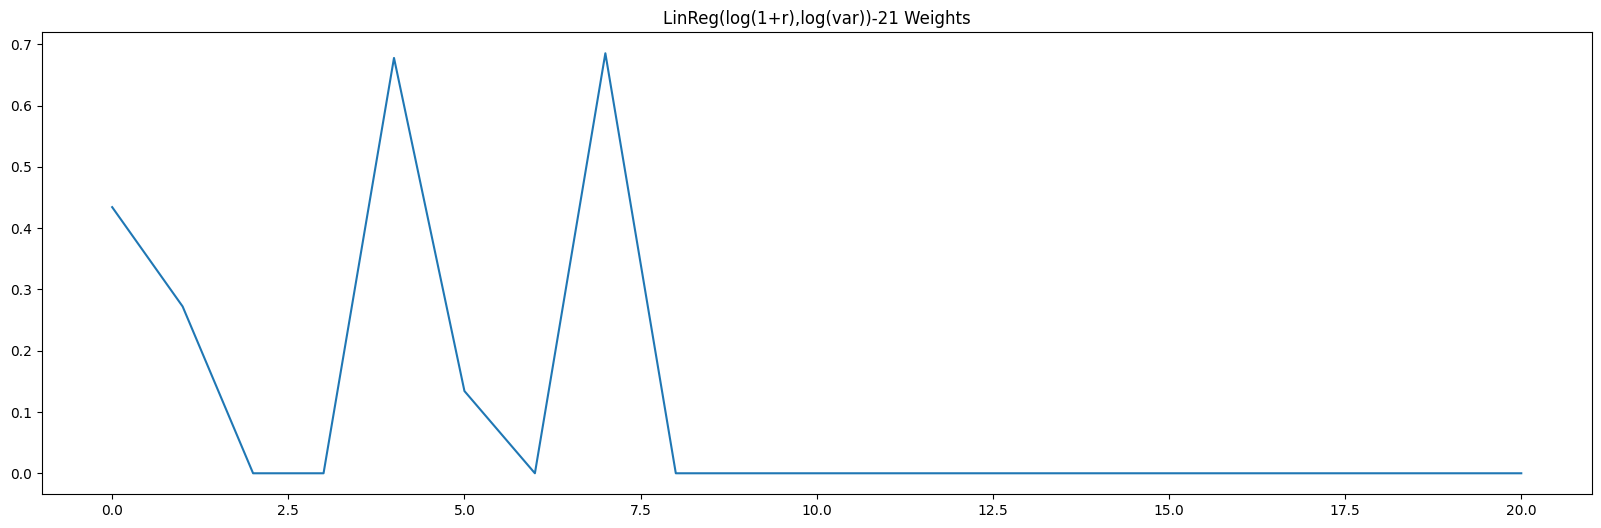

In [17]:
method = "LinReg(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

methods[method]["model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [18]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(np.log(1+returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Individual Linear Regression (log(1+return), log(variance))

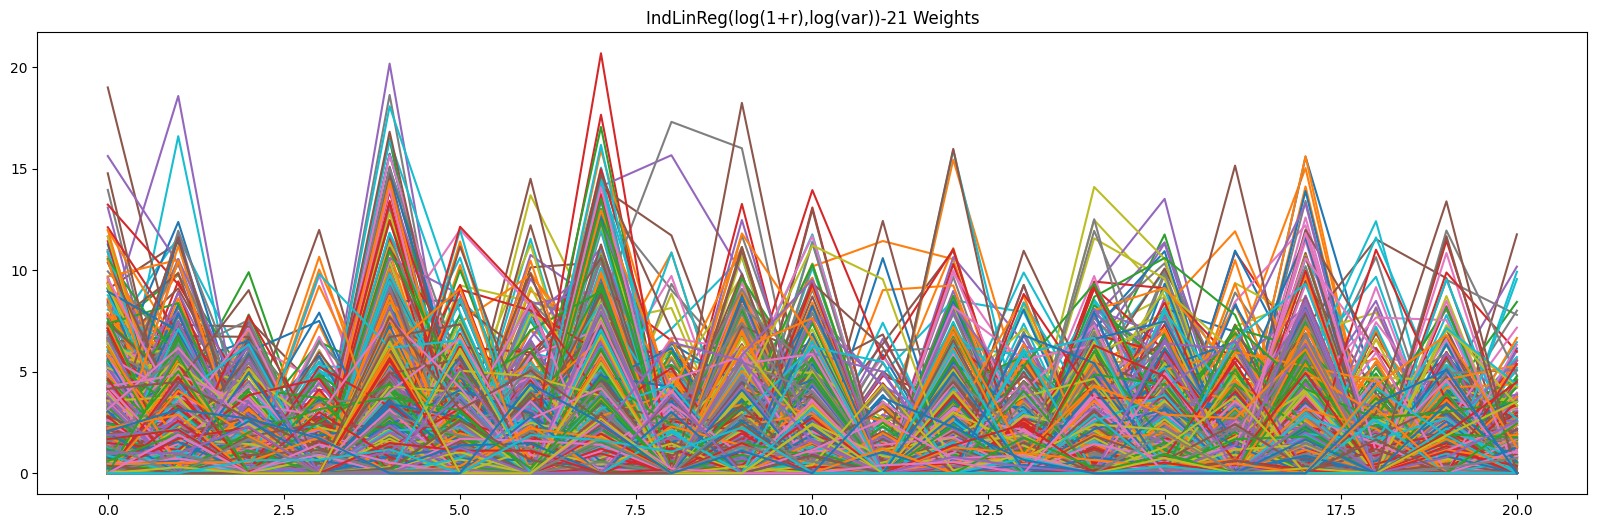

In [19]:
method = "IndLinReg(log(1+r),log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in all_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(np.log(1 + returns_df[stock][i - window:i]))
            B.append(np.log(variance))

    methods[method][stock + "model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
for stock in all_stocks:
    plt.plot(methods[method][stock + "model"].coef_)
plt.title(method + " Weights")
plt.show()

In [20]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method][stock + "model"].predict(np.log(1+returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Linear Regression (return^2, log(variance))

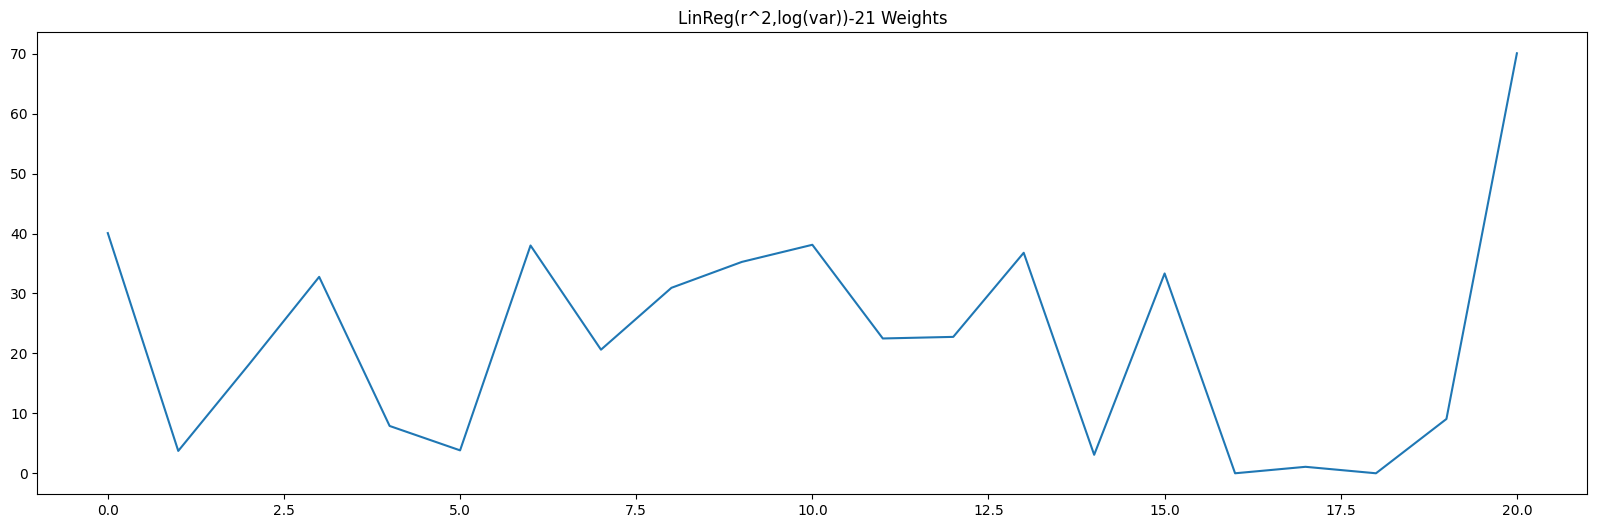

In [ ]:
method = "LinReg(r^2,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        variance = returns_df[stock][i:i + forecast_horizon].var()
        if variance > 0: # If variance is 0, we cannot take the log
            A.append(returns_df[stock][i - window:i] ** 2)
            B.append(np.log(variance))

methods[method]["model"] = get_linear_regression_model(A, B)

plt.figure(figsize=(20, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.show()

In [ ]:
for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method][stock].predict(returns_df[stock][i - window: i].values.reshape(1, -1) ** 2))**0.5 for stock in all_stocks}
    
    gather_portfolio_metrics(method, i, volatility)

AttributeError: 'list' object has no attribute 'predict'

AttributeError: 'list' object has no attribute 'predict'

Random Forest Method

In [ ]:
def get_random_forest_model(A, B):
    # Fit a random forest
    model = RandomForestRegressor()
    model.fit(np.array(A), np.array(B))
    A.clear()
    B.clear()

    return model

Random Forest (return, log(variance))

In [ ]:
method = "RandFor(r,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i])
        B.append(np.log(returns_df[stock][i : i + forecast_horizon].var()))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest (return^2, log(variance))

In [ ]:
method = "RandFor(r^2,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(returns_df[stock][i - window:i]**2)
        B.append(np.log(returns_df[stock][i : i + forecast_horizon].var()))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(returns_df[stock][i - window: i].values.reshape(1, -1)**2))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest (|return|, log(variance))

In [ ]:
method = "RandFor(|r|,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(abs(returns_df[stock][i - window:i]))
        B.append(np.log(returns_df[stock][i : i + forecast_horizon].var()))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(abs(returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Random Forest (log(1+return), log(variance))

In [ ]:
method = "RandFor(|r|,log(var))" + "-" + str(window)
reset_portfolio_metrics(method)

# Iterate over each window of returns
for stock in training_stocks:
    for i in range(train_start, train_end, forecast_horizon):
        # Append squared returns and variance of returns to A and B respectively
        A.append(np.log(1 + returns_df[stock][i - window:i]))
        B.append(np.log(returns_df[stock][i : i + forecast_horizon].var()))

methods[method]["model"] = get_random_forest_model(A, B)

for i in range(test_start, test_end, forecast_horizon):
    # 
    volatility = {stock: np.exp(methods[method]["model"].predict(np.log(1 + returns_df[stock][i - window: i].values.reshape(1, -1))))**0.5 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

Portfolios' Performances

In [ ]:
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Std": [np.std(portfolio["returns"]) * 252**0.5 for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) / (np.std(portfolio["returns"]) * 252**0.5) for portfolio in methods.values()]
}

display(pd.DataFrame(portfolios_df).sort_values('Sharpe', ascending=False).reset_index(drop=True), pd.DataFrame(portfolios_df).sort_values('Std', ascending=True).reset_index(drop=True))

,Portfolio,Std,Return,Sharpe
0,"IndLinReg(log(1+r),log(var))-21",0.192751,0.235864,1.223672
1,PerfectPrediction+21,0.170286,0.199996,1.174475
2,"LinReg(log(1+r),log(var))-21",0.188099,0.204634,1.087907
3,ExponentialWeight-21,0.175631,0.189612,1.079606
4,EqualWeight,0.185493,0.200196,1.079264
5,Sample-21,0.175983,0.188885,1.073315
6,"RandFor(r,log(var))-21",0.178663,0.191635,1.072605
7,"RandFor(r^2,log(var))-21",0.177808,0.190486,1.071300
8,"RandFor(|r|,log(var))-21",0.178500,0.190979,1.069908
9,"IndLinReg(r^2,var)-21",0.176333,0.188535,1.069196


,Portfolio,Std,Return,Sharpe
0,PerfectPrediction+21,0.170286,0.199996,1.174475
1,"LinReg(r^2,var)-21",0.175357,0.186289,1.062344
2,ExponentialWeight-21,0.175631,0.189612,1.079606
3,Sample-21,0.175983,0.188885,1.073315
4,ExponentialWeight-63,0.176032,0.187935,1.067616
5,ExponentialWeight-126,0.176048,0.187822,1.066879
6,ExponentialWeight-252,0.176048,0.187835,1.066948
7,"IndLinReg(r^2,var)-21",0.176333,0.188535,1.069196
8,Sample-63,0.176864,0.186469,1.054311
9,Sample-126,0.177199,0.184447,1.040902


Portfolio Value (initial investment: 1$)

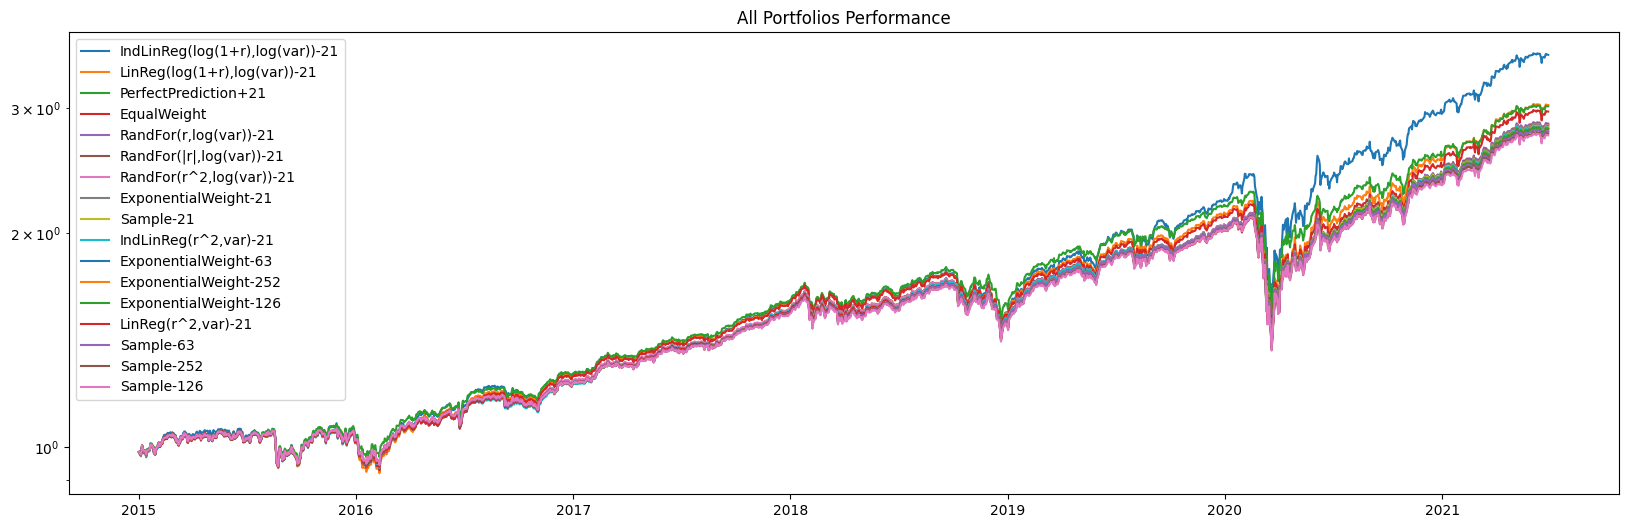

In [ ]:
# Iterate over each portfolio in methods
for portfolio in methods.values():
    # Initialize the value list with a starting value of 1
    portfolio["value"] = [1]

    # Calculate the cumulative value of the portfolio
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret + 1) * portfolio["value"][-1])

# Get the dates for the test period
dates = returns_df.iloc[test_start:test_end, 0]

# Sort the methods by the final value of the portfolio, in descending order
sorted_methods = sorted(methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

# Plot the performance of all portfolios
plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"][1:], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

Mean Squared Error

In [ ]:
def calculate_mse(actual, predicted, stocks=all_stocks):
    mse = []
    for stock in stocks:
        mse.append(mean_squared_error(actual[stock + " predicted volatility"], predicted[stock + " predicted volatility"]))
    return np.mean(mse)

Methods' Performace

In [ ]:
methods_df = {
    "Method": [method for method in methods if method != "EqualWeight"],
    "MSE All Stocks": [calculate_mse(methods["PerfectPrediction+" + str(forecast_horizon)], methods[method]) for method in methods if method != "EqualWeight"],
    "MSE Trained Stocks": [calculate_mse(methods["PerfectPrediction+" + str(forecast_horizon)], methods[method], training_stocks) for method in methods if method != "EqualWeight"],
    "MSE Other Stocks": [calculate_mse(methods["PerfectPrediction+" + str(forecast_horizon)], methods[method], other_stocks) for method in methods if method != "EqualWeight"]
}

display(pd.DataFrame(methods_df).sort_values('MSE All Stocks', ascending=True).reset_index(drop=True))

,Method,MSE
0,PerfectPrediction+21,0.000000
1,"RandFor(r^2,log(var))-21",0.000086
2,"RandFor(|r|,log(var))-21",0.000089
3,"RandFor(r,log(var))-21",0.000089
4,ExponentialWeight-252,0.000116
5,ExponentialWeight-126,0.000116
6,ExponentialWeight-63,0.000117
7,ExponentialWeight-21,0.000122
8,"LinReg(r^2,var)-21",0.000123
9,"IndLinReg(r^2,var)-21",0.000133


In [ ]:
display(pd.DataFrame(methods_df).sort_values('MSE Trained Stocks', ascending=True).reset_index(drop=True))
display(pd.DataFrame(methods_df).sort_values('MSE Other Stocks', ascending=True).reset_index(drop=True))

In [ ]:
# del window, i, volatility, method, train_start, train_end, test_start, test_end, forecast_horizon, windows, training_stocks, A, B, variance, dates, methods, portfolio, stock, weights, ret, returns_matrix, sorted_methods